<a href="https://colab.research.google.com/github/anubhavgupta1/DeepLearning/blob/master/13_Deep_CNN_Torch_Vision_Models_Zoo_INCEPTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy


In [0]:
def find_parameters(x):
  total_parameters = 0
  for param in x:
    a = param.shape
    print(a)
    i = 0
    temp = 1
    while i < len(a):
      temp = temp * a[i]
      i = i + 1
    total_parameters = total_parameters + temp
  print("Total Parameters = ",total_parameters)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#Transfer Learning
# Using a model that is pre-trained on large comprehensive datasets and transferring that learning by modifying it slightly to perform the task at hand.

## Dataset, transforms, and visualisation

In [0]:
#Z-score normalization
#z_i = (x_i - x_mean)/x_std_deviation now z_i will lie between ( 0 and 1 ) 
#The main difference comes after normalizing the values as it reduces the skewness in our data, 
#it's just hypothetical that at mean=0.5 and std=0.5, CNNs tend to train better.

In [0]:
#sequence of operations in a pipeline

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  #CIFAR10 32 x 32 ==> 224 X 224 { VGG16, ResNet 224 x 224 }
    transforms.ToTensor(), #conversion into tensor 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Z-score normalization
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [9]:
#download of CIFAR 10 IMAGES

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
#CIFAR10 has 10 classes
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [13]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
5


In [0]:
#How would you de-normalize an image after it undergoes transforms.Normalize((0.3, 0.3, 0.3), (0.4, 0.4, 0.4))
#npimg = img.numpy() / 2.5 + 0.3


In [0]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 #un-normalize image pixels
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 3, 224, 224 ===> 224, 224, 3
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

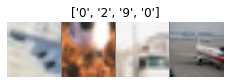

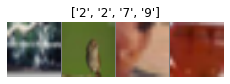

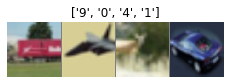

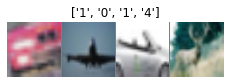

In [16]:
for i in range(4):
    show_batch_images(trainloader)

## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [0]:
#5 different types of Inception modules are implemented in torchvision.models.inception_v3()

In [18]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [19]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
for param in inception.parameters():
    param.requires_grad = False

In [0]:
#Now we need to change number of output classes noy only in final output but in auxilliary output also 

In [0]:
#change in auxilliary output
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [25]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [0]:
# auxilliary parameters = 7690

In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [28]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [0]:
# FC parameters = 20490
#total parameters need to train = 7690+ 20490 = 28180 

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [31]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [0]:
#Here we need to update evaluation function slightly,
# if we want to evaluate the auxilliary output.
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.11
Iteration: 0/3125, Loss: 3.11
Min loss 2.99
Min loss 2.99
Min loss 2.97
Min loss 2.94
Min loss 2.80
Min loss 2.72
Min loss 2.68
Min loss 2.64
Min loss 2.59
Min loss 2.57
Iteration: 100/3125, Loss: 2.72
Min loss 2.51
Min loss 2.49
Min loss 2.45
Min loss 2.35
Min loss 2.33
Min loss 2.27
Min loss 2.20
Min loss 2.19
Iteration: 200/3125, Loss: 2.55
Min loss 2.12
Min loss 2.05
Min loss 2.04
Iteration: 300/3125, Loss: 2.65
Min loss 1.93
Min loss 1.93
Min loss 1.85
Min loss 1.84
Min loss 1.81
Iteration: 400/3125, Loss: 1.81
Min loss 1.77
Iteration: 500/3125, Loss: 2.26
Min loss 1.74
Iteration: 600/3125, Loss: 2.33
Min loss 1.66
Iteration: 700/3125, Loss: 1.94
Min loss 1.66
Iteration: 800/3125, Loss: 1.96
Min loss 1.58
Min loss 1.56
Min loss 1.55
Iteration: 900/3125, Loss: 1.97
Min loss 1.52
Iteration: 1000/3125, Loss: 2.12
Min loss 1.45
Iteration: 1100/3125, Loss: 2.44
Min loss 1.38
Iteration: 1200/3125, Loss: 2.53
Min loss 1.24
Iteration: 1300/3125, Loss: 2.49
Iteration: 1400/31

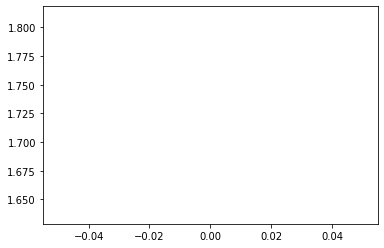

In [35]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [36]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

46.268 45.56
